In [48]:
import PyKDL as kdl
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf
import numpy as np
import copy
from itertools import repeat

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj
import robot_visualize as rbvis

np.set_printoptions(suppress=True)


act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from utils import EpisodicDataset
from utils import find_all_hdf5, flatten_list, get_norm_stats
from utils import load_data # data functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import EPACTPolicy, ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/train_act_scara_3cam/3cam_epact_v1/"

config_path = ckpt_path + "config.pkl"
# step = 500000
# policy_model_path = ckpt_path + "policy_step_%i_seed_0.ckpt"%step
policy_model_path = ckpt_path + "policy_step_400000_seed_0.ckpt"

stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = EPACTPolicy(policy_config)
loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]

print("loading EPACTPolicy policy success")

{'lr': 1e-05, 'num_queries': 100, 'kl_weight': 10, 'ep_weight': 1.0, 'hidden_dim': 512, 'dim_feedforward': 3200, 'lr_backbone': 1e-05, 'backbone': 'resnet18', 'enc_layers': 4, 'dec_layers': 7, 'nheads': 8, 'camera_names': ['wrist', 'wrist_down', 'top'], 'vq': False, 'vq_class': None, 'vq_dim': None, 'action_dim': 5, 'state_dim': 4, 'no_encoder': False}
EPACT Args:  Namespace(lr=1e-05, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='resnet18', dilation=False, position_embedding='sine', camera_names=['wrist', 'wrist_down', 'top'], enc_layers=4, dec_layers=7, dim_feedforward=3200, hidden_dim=512, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='EPACT', task_name='act_demo_z1_push_red', seed=0, num_steps=2000, kl_weight=10, chunk_size=None, temporal_agg=False, use_vq=False, vq=False, vq_class=None, vq_dim=None,

In [50]:
urdf_path =  "/home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf"
print("URDF Path: ", urdf_path)
(ok, tree)  = kdl_parser_py.urdf.treeFromFile(urdf_path)
print("kdl_parse urdf ok?: ", ok)
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)


URDF Path:  /home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf
kdl_parse urdf ok?:  True


In [51]:
camera_names = policy_config["camera_names"]
print(camera_names)

['wrist', 'wrist_down', 'top']


In [52]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

def pre_process_multi_img(curr_images):
    # a list of images [w, h, 3]
    curr_image = np.stack(curr_images, axis=0)
    img_torch = torch.from_numpy(curr_image)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

def post_process_all_actions(all_actions):
    # post process all actions
    joint_states_traj = []
    actual_actions = []
    for i, raw_action in enumerate(all_actions):
        actual_action = post_process_action(raw_action)
        actual_actions.append(actual_action)
    actual_actions = np.asarray(actual_actions)
    # print(actual_actions)
    return actual_actions

def get_camera_in_world_and_init(ee_poses_raw, init_states=None):
    transformation_matrix, rot_mat_ext, translation_mat= trans.kdl_frame_to_mat(ee_poses_raw[0])
    ee_in_world_init = transformation_matrix
    world_T_init = np.linalg.inv(ee_in_world_init)

    ee_in_world_all = []
    ee_in_init_all = []
    ee_in_init_all_pos = []
    ee_in_world_all_pos = []
    for ee_pose in ee_poses_raw:
        ee_in_world_all_pos.append([ee_pose.p[0], ee_pose.p[1], ee_pose.p[2], 1])
        ee_in_world, _, _= trans.kdl_frame_to_mat(ee_pose)
        ee_in_world_all.append(ee_in_world)
        ee_in_init = world_T_init.dot(ee_in_world)
        ee_in_init_all.append(ee_in_init)
        ee_in_init_all_pos.append(ee_in_init[:3, 3])
        
        # print("ee rpy: ", tf.euler_from_matrix(ee_in_init, 'rxyz'))

    ee_in_init_all_pos = np.asarray(ee_in_init_all_pos)
    ee_in_world_all_pos = np.asarray(ee_in_world_all_pos)
    ee_in_init_all = np.asarray(ee_in_init_all)
    return  ee_in_init_all_pos, ee_in_world_all_pos, ee_in_init_all

def repeater(data_loader):
    epoch = 0
    for loader in repeat(data_loader):
        for data in loader:
            yield data
        print(f'Epoch {epoch} done')
        epoch += 1

In [53]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("../hitbot_model.urdf")
print("ok: ", ok)
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)
rgb_p = np.asarray([[429.76348876953125, 0.0, 321.4649658203125, 
                     0.0, 0.0, 429.129150390625, 242.32749938964844, 
                     0.0, 0.0, 0.0, 1.0, 0.0]]).reshape([3, 4])
rgb_p

ok:  True


array([[429.76348877,   0.        , 321.46496582,   0.        ],
       [  0.        , 429.12915039, 242.32749939,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [54]:
dataset_path_list = find_all_hdf5("/mnt/data1/act/train_act_scara_3cam/data1/", skip_mirrored_data=False)
norm_stats, all_episode_len = get_norm_stats(dataset_path_list)

camera_names = ['wrist', 'wrist_down', 'top']
train_episode_ids = [0, 1]
train_episode_len = [all_episode_len[i] for i in train_episode_ids]

val_episode_ids = [0, 1]
val_episode_len = [all_episode_len[i] for i in val_episode_ids]

chunk_size = 64

dataset_dir = "/mnt/data1/act/train_act_scara_3cam/data1/"

TASK_CONFIGS = {
        'epact':{
        'dataset_dir': dataset_dir + '/train_act_scara_3cam',
        'num_episodes': 100,
        'episode_len': 300,
        'camera_names': ['wrist', 'wrist_down', 'top']
    }
}
task_config = TASK_CONFIGS['epact']
name_filter = task_config.get('name_filter', lambda n: True)
batch_size_train = 1
batch_size_val = 1

chunk_size = 100
skip_mirrored_data = False
load_pretrain = False
train_ratio = 0.99
policy_class = "EPACT"
train_dataloader,val_dataloader, stats, _ = load_data(dataset_dir, 
                                                       name_filter, 
                                                       camera_names, 
                                                       batch_size_train, 
                                                       batch_size_val, 
                                                       chunk_size,
                                                       skip_mirrored_data,
                                                       load_pretrain,
                                                       policy_class,
                                                       stats_dir_l=None,
                                                       sample_weights=None,
                                                       train_ratio=train_ratio)
train_dataloader = repeater(train_dataloader)


Found 51 hdf5 files
Found 51 hdf5 files


Data from: ['/mnt/data1/act/train_act_scara_3cam/data1/']
- Train on [50] episodes
- Test on [1] episodes


Found 51 hdf5 files
Norm stats from: ['/mnt/data1/act/train_act_scara_3cam/data1/']
train_episode_len: [118, 124, 132, 135, 103, 106, 129, 116, 127, 153, 108, 121, 136, 140, 98, 137, 111, 177, 154, 161, 135, 116, 90, 123, 168, 135, 168, 107, 118, 128, 136, 121, 110, 101, 154, 151, 104, 165, 110, 125, 117, 120, 128, 124, 104, 139, 114, 117, 175, 118], val_episode_len: [144], train_episode_ids: [13 23 15 29 30 22  9 39  1 41  5  2 17 50  7  0 12 44 40 37  8 42 21 43
 34 31 19  6 11 16 14 46 26 27 10 32  3 49 24 18 35 36  4 28 47 38 20 48
 25 33], val_episode_ids: [45]
val data:  /mnt/data1/act/train_act_scara_3cam/data1/episode_5.hdf5
URDF Path:  /home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf
kdl_parse urdf ok?:  True
augment_images:  False
Initializing transformations
URDF Path:  /home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf
k

In [64]:
data = next(train_dataloader)
image_data, qpos_data, action_data, is_pad, end_pose_data = data
image_data, qpos_data, action_data, is_pad, end_pose_data = image_data.cuda(), qpos_data.cuda(), action_data.cuda(), is_pad.cuda(), end_pose_data.cuda()

print("image_data", image_data.shape)
print("qpos_data", qpos_data.shape)
print("action_data", action_data.shape)
print("is_pad", is_pad.shape)
print("end_pose_data", end_pose_data.shape)


image_data torch.Size([1, 3, 3, 480, 640])
qpos_data torch.Size([1, 4])
action_data torch.Size([1, 100, 5])
is_pad torch.Size([1, 100])
end_pose_data torch.Size([1, 100, 6])


In [65]:
all_actions, end_poses = policy(qpos_data, image_data)


In [66]:
end_pose_gt = end_pose_data.squeeze(0).cpu().detach().numpy()
end_pose_gt.shape

(100, 6)

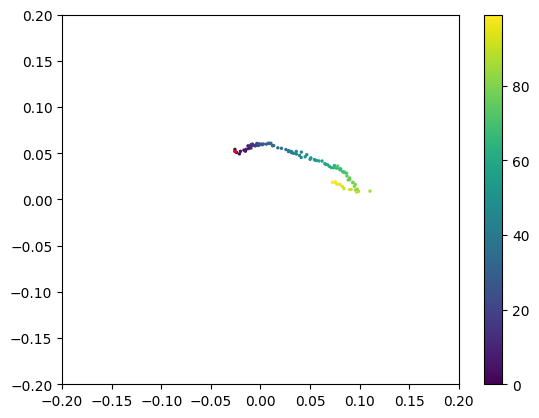

In [62]:
end_pose_gt = end_pose_data.squeeze(0).cpu().detach().numpy()
plt.scatter(end_pose_gt[:, 0], end_pose_gt[:, 1], c=range(len(end_pose_gt)), s=2)

plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.colorbar()
plt.scatter(end_pose_gt[0, 0], end_pose_gt[0, 1], c='r', s=2)


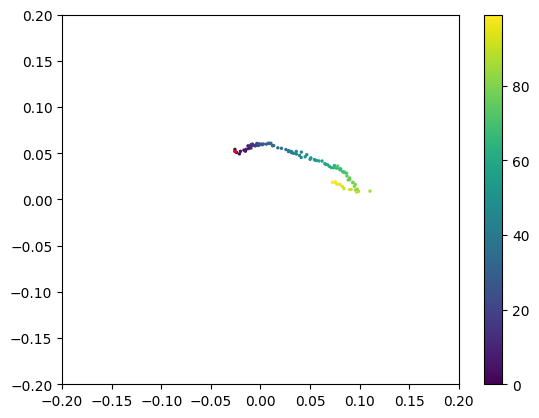

In [63]:
end_poses_hat = end_poses.squeeze(0).cpu().detach().numpy()
plt.scatter(end_poses_hat[:, 0], end_poses_hat[:, 1], c=range(len(end_poses_hat)), s=2)

plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.colorbar()
plt.scatter(end_poses_hat[0, 0], end_poses_hat[0, 1], c='r', s=2)


In [67]:
h5data_file = "/mnt/data1/act/train_act_scara_3cam/data1/episode_8.hdf5"

with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        index = 0
        qpos_np = root["/observations/qpos"][index]
        img_wrist_up_np = root["/observations/images/wrist"][index]
        img_wrist_down_np = root["/observations/images/wrist_down"][index]
        img_top_np = root["/observations/images/top"][index]

        qpos_all =  root["/observations/qpos"][()]

        curr_images = [img_wrist_up_np, img_wrist_down_np, img_top_np]

        action_obs_np = root["action"][()]
        qpos = pre_process_qpos(qpos_np)
        curr_images_torch = pre_process_multi_img(curr_images)
        # print("qpos: ",qpos.shape)
        all_actions, end_poses = policy(qpos, curr_images_torch)
        all_actions = all_actions.squeeze(0).cpu().numpy()
        end_poses = end_poses.squeeze(0).cpu().numpy()

        print("all_actions: ", all_actions.shape)
        print("end_poses: ", end_poses.shape)
        print("action_obs_np: ", action_obs_np.shape)

        # actual_action = post_process_action(raw_action)
        # print("actual action %i"%index, actual_action)


action_obs_np = action_obs_np[index:]
qpos_all = np.asarray(qpos_all)
qpos_all = qpos_all[index:]


all_actions:  (100, 5)
end_poses:  (100, 6)
action_obs_np:  (107, 5)


In [113]:
image_actions_list = []
with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        for index in range(0, len(action_obs_np)):
            qpos_np = root["/observations/qpos"][index]
            img_wrist_up_np = root["/observations/images/wrist"][index]
            img_wrist_down_np = root["/observations/images/wrist_down"][index]
            img_top_np = root["/observations/images/top"][index]

            curr_images = [img_wrist_up_np, img_wrist_down_np, img_top_np]
            qpos = pre_process_qpos(qpos_np)
            curr_images_torch = pre_process_multi_img(curr_images)
            all_actions, end_poses = policy(qpos, curr_images_torch)
            all_actions = all_actions.squeeze(0).cpu().numpy()
            end_poses = end_poses.squeeze(0).cpu().numpy()

            image_actions_list.append([img_wrist_up_np.copy(), all_actions, copy.deepcopy(end_poses)])

In [119]:
start_ts = 50
max_episode_len = 200
image_actions_list = []
with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        qpos = root['/observations/qpos'][start_ts]
        action = root['/action'][()]
        original_action_shape = action.shape
        episode_len = original_action_shape[0]
        print("episode_len:", episode_len)
        action = action[max(0, start_ts - 1):] # hack, to make timesteps more aligned
        action_len = episode_len - max(0, start_ts - 1) # hack, to make timesteps more aligned
        print("action_len:", action_len)
        padded_action = np.zeros((max_episode_len, original_action_shape[1]), dtype=np.float32)
        padded_action[:action_len] = action

        img_wrist_up_np = root["/observations/images/wrist"][start_ts]
        img_wrist_down_np = root["/observations/images/wrist_down"][start_ts]
        img_top_np = root["/observations/images/top"][start_ts]
        curr_images = [img_wrist_up_np, img_wrist_down_np, img_top_np]
        qpos_processed = pre_process_qpos(qpos)
        curr_images_torch = pre_process_multi_img(curr_images)
        all_actions, end_poses = policy(qpos_processed, curr_images_torch)
        all_actions = all_actions.squeeze(0).cpu().numpy()
        end_poses = end_poses.squeeze(0).cpu().numpy()





episode_len: 107
action_len: 58


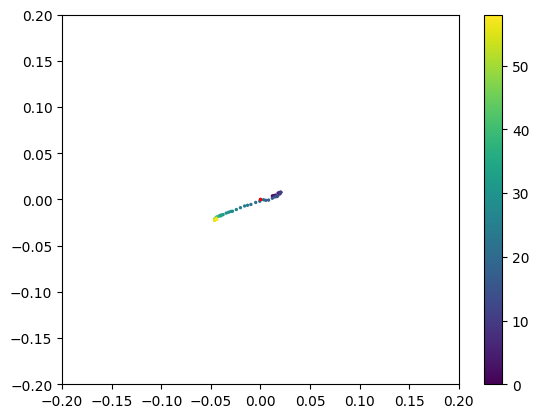

In [122]:
# GT ENDPOSE
all_actions = np.vstack([np.append(qpos, 0), action])
ee_poses, ee_poses_raw, link_poses_list = rbvis.get_camera_poses(all_actions, fk_solver, chain)
ee_pts_init, ee_in_world_all_pos, ee_in_init_all = get_camera_in_world_and_init(ee_poses_raw)
ee_pose = rbvis.batch_transform_to_xyzyrp_transformations(ee_in_init_all)


plt.scatter(ee_pose[:, 0], ee_pose[:, 1], c=range(len(ee_pose)), s=2)
plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.colorbar()
plt.scatter(ee_pose[0, 0], ee_pose[0, 1], c='r', s=2)


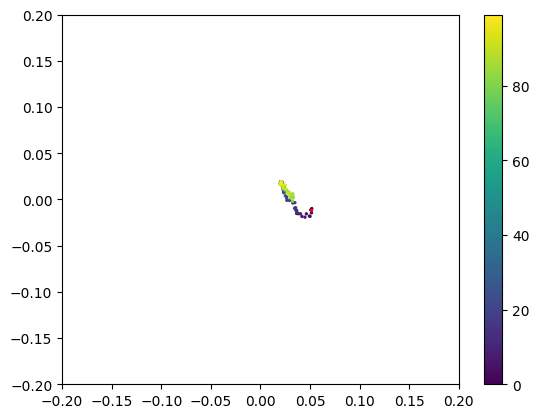

In [123]:
plt.scatter(end_poses[:, 0], end_poses[:, 1], c=range(len(end_poses)), s=2)

plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.colorbar()
plt.scatter(end_poses[0, 0], end_poses[0, 1], c='r', s=2)


In [98]:
gt_all_actions = action_obs_np[start_ts:start_ts+policy_config["num_queries"]]
qpos_init = qpos_all[start_ts]
print("gt+all_actions: ", gt_all_actions.shape)


gt+all_actions:  (100, 5)


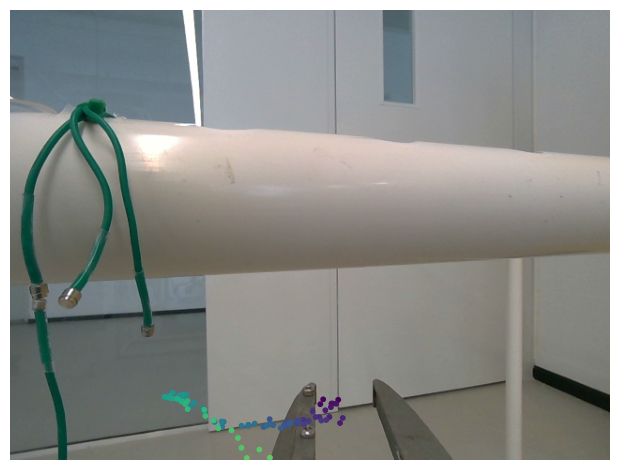

In [99]:
img_plot, all_actions, end_poses = image_actions_list[ts]
actual_actions = post_process_all_actions(all_actions)
vis_actions = actual_actions # Predicted action
# vis_actions = action_obs_np # Ground truth action
# vis_actions = qpos_all # Ground truth qpos


rbvis.paint_action_in_image(img_plot, vis_actions, rgb_p, fk_solver, chain, save_path=None)

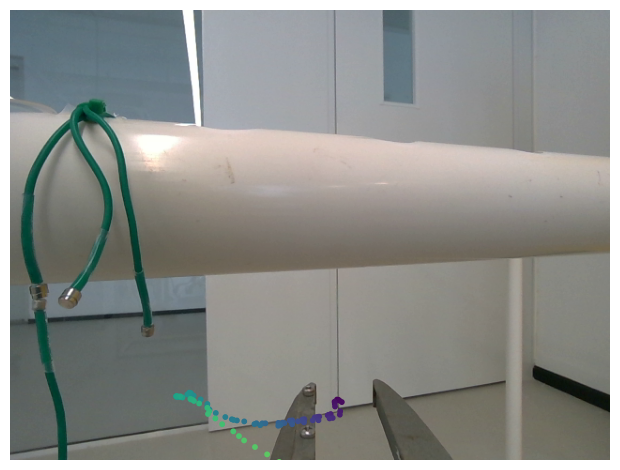

In [100]:
img_plot, all_actions, end_poses = image_actions_list[ts]
# actual_actions = post_process_all_actions(all_actions)
# vis_actions = actual_actions # Predicted action
vis_actions = gt_all_actions # Ground truth action
# vis_actions = qpos_all # Ground truth qpos


rbvis.paint_action_in_image(img_plot, vis_actions, rgb_p, fk_solver, chain, save_path=None)

In [89]:
qpos_np

array([-0.1161447 ,  0.42921662, -1.733276  ,  1.323272  ], dtype=float32)

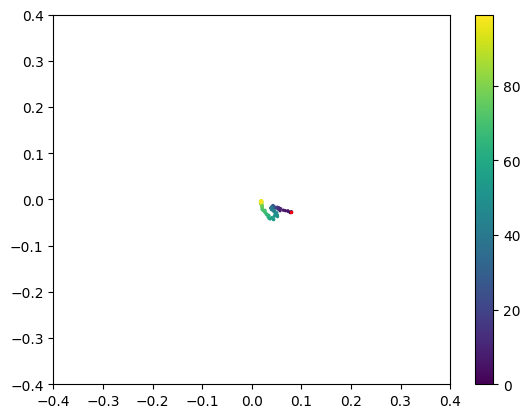

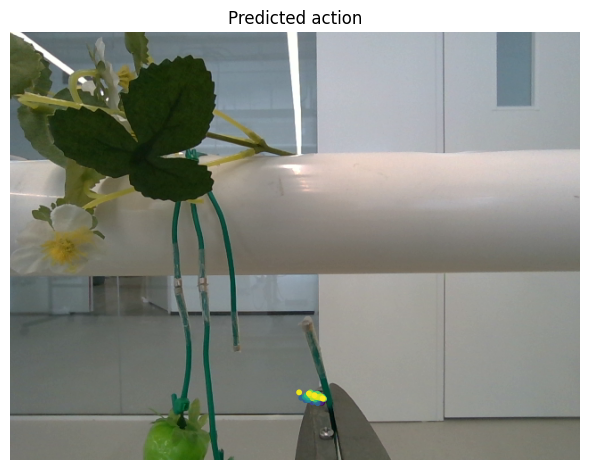

In [27]:
fig, ax = plt.subplots()  # Create a single figure and axis
plt_fig_ax = [fig, ax]
title = "Predicted action"
# title = "Ground truth action"
vis_len = 100

for i in range(0, len(action_obs_np)):
    img_plot, all_actions = image_actions_list[i]
    actual_actions = post_process_all_actions(all_actions)
    vis_actions = actual_actions # Predicted action
    # if i + vis_len >= len(action_obs_np):
    #     break
    # vis_actions = action_obs_np[i:i+vis_len] # Ground truth action
    # vis_actions = qpos_all # Ground truth qpos
    rbvis.paint_action_in_image(img_plot, vis_actions, rgb_p, fk_solver, chain, save_path="./temp/%05i.jpg"%i, plt_fig_ax=plt_fig_ax, title=title)


# ffmpeg -pattern_type glob -i "*.jpg" -framerate 10 action_prediction.gif


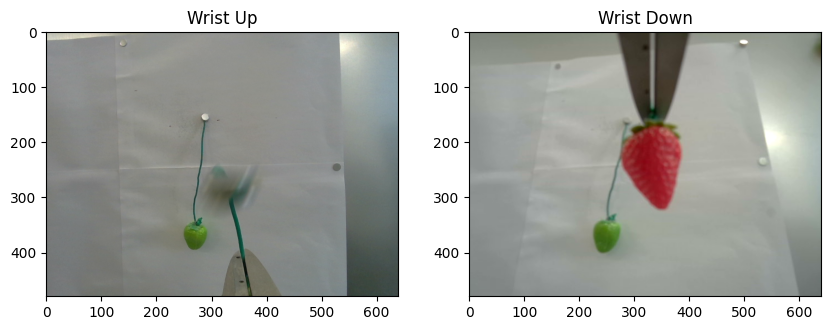

In [118]:
# plot image of wrist up and wrist down on left and right 

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Wrist Up')
plt.imshow(cv.cvtColor(img_wrist_up_np, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Wrist Down')
plt.imshow(cv.cvtColor(img_wrist_down_np, cv.COLOR_BGR2RGB))
plt.show()


In [28]:

actual_actions = post_process_all_actions(all_actions)

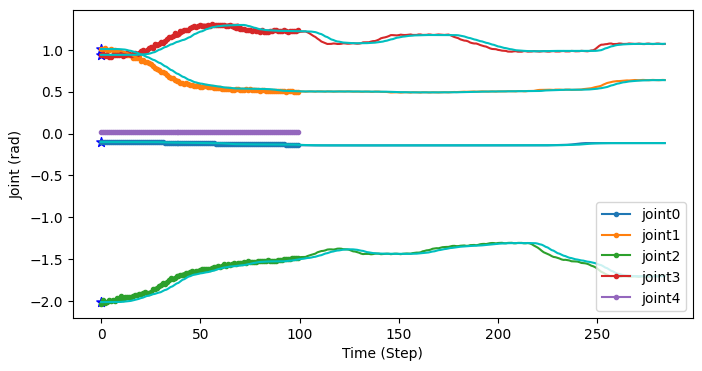

In [34]:
# plot all joint states and label them
plt.figure(figsize=(8, 4))
plt.plot(actual_actions[:, 0], marker=".", label='joint0')
plt.plot(actual_actions[:, 1], marker=".", label='joint1')
plt.plot(actual_actions[:, 2], marker=".", label='joint2')
plt.plot(actual_actions[:, 3], marker=".", label='joint3')
plt.plot(actual_actions[:, 4], marker=".", label='joint4')

plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.legend()


plt.scatter(0, qpos_np[0], marker="*", c="b", s=50, label='joint0')
plt.scatter(0, qpos_np[1], marker="*", c="b", s=50, label='joint1')
plt.scatter(0, qpos_np[2], marker="*", c="b", s=50, label='joint2')
plt.scatter(0, qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')
steps_plot = np.arange(0, len(action_obs_np[:]), 1)
plt.plot(steps_plot, action_obs_np[:, 0],  c="C%i"%(0 ), label='joint0')
plt.plot(steps_plot, action_obs_np[:, 1],  c="C%i"%(1 ), label='joint1')
plt.plot(steps_plot, action_obs_np[:, 2],  c="C%i"%(2 ), label='joint2')
plt.plot(steps_plot, action_obs_np[:, 3],  c="C%i"%(3 ), label='joint3')


steps_plot = np.arange(0, len(qpos_all[:]), 1)
plt.plot(steps_plot, qpos_all[:, 0],  c="c", label='joint0')
plt.plot(steps_plot, qpos_all[:, 1],  c="c", label='joint1')
plt.plot(steps_plot, qpos_all[:, 2],  c="c", label='joint2')
plt.plot(steps_plot, qpos_all[:, 3],  c="c", label='joint3')

In [121]:
# vis_actions = action_obs_np # Ground truth action
vis_actions = actual_actions # Predicted action
# vis_actions = qpos_all # Ground truth qpos
cam_poses, cam_poses_raw, link_poses_list = rbvis.get_camera_poses(vis_actions, fk_solver, chain)



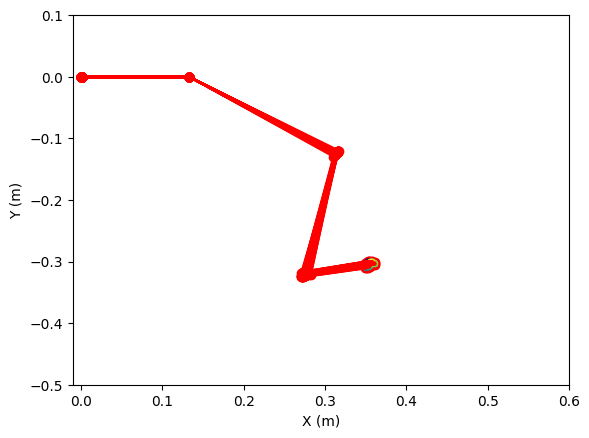

In [122]:
rbvis.plot_robot_2d_xy_batch(link_poses_list)
plt.scatter(cam_poses[:, 0], cam_poses[:, 1], c=range(len(cam_poses)), marker='.')
plt.show()

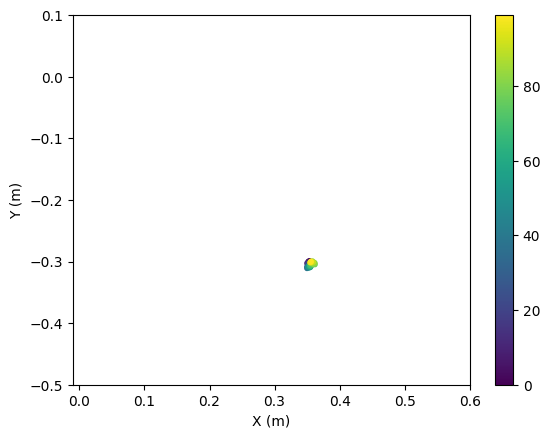

: 

In [123]:
plt.scatter(cam_poses[:, 0], cam_poses[:, 1], c=range(len(cam_poses)), marker='.')
plt.ylim([-0.5, 0.1])
plt.xlim([-0.01, 0.6])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar()

<Figure size 1000x800 with 0 Axes>

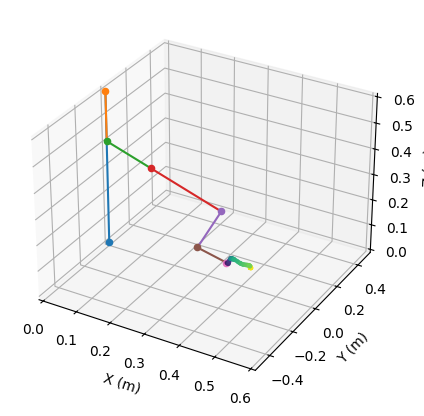

In [27]:
fig = plt.figure(figsize=(10, 8))
ax = rbvis.plot_robot(link_poses_list[0])

# plot ee_poses xyz
ax.scatter(cam_poses[:, 0], cam_poses[:, 1], cam_poses[:, 2], c=range(len(cam_poses)), marker='.')
ax.plot(cam_poses[:, 0], cam_poses[:, 1], cam_poses[:, 2], c='r')

ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

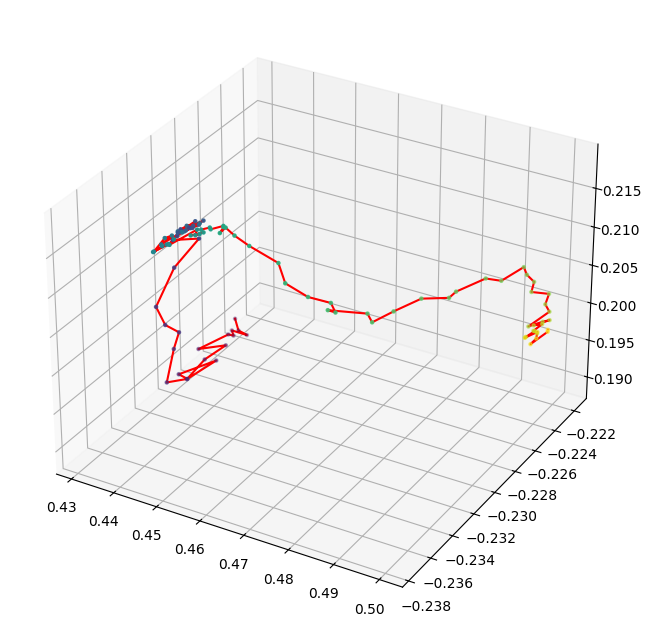

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# plot ee_poses xyz
ax.scatter(cam_poses[:, 0], cam_poses[:, 1], cam_poses[:, 2], c=range(len(cam_poses)), marker='.')
ax.plot(cam_poses[:, 0], cam_poses[:, 1], cam_poses[:, 2], c='r')


# ax.set_ylim([-0.5, 0.5])
# ax.set_zlim([0, 0.3])
# ax.set_xlim([0, 0.6])

ax.view_init(elev=30, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

# Image Projection

In [29]:
cam_pts_init, cam_in_world_all_pos = rbvis.get_camera_in_world_and_init(cam_poses_raw)
cam_pts_init[0]

array([0., 0., 0.])

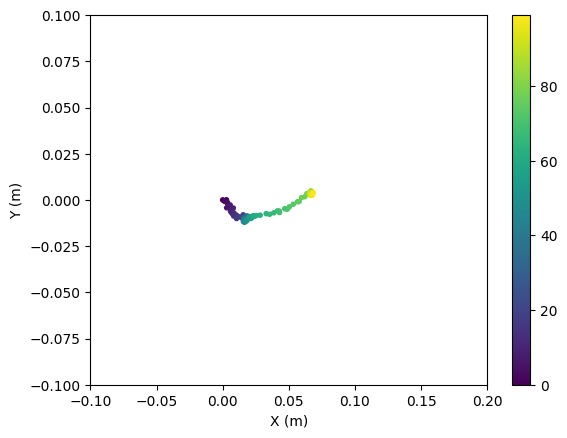

In [30]:
plt.scatter(cam_pts_init[:, 0], cam_pts_init[:, 1], c=range(len(cam_pts_init)), marker='.')
# plt.scatter(pts_init[:, 0], pts_init[:, 1], c=range(len(pts_init)), marker='.')
plt.ylim([-0.1, 0.1])
plt.xlim([-0.1, 0.2])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar()

In [33]:
# cam_pts_init to ee_pts_cam (ee_pts_init, init is the same as cam)
camera_T_ee = trans.states2SE3([0.12, -0.008, -0.0485, 0, 0, 0])
ee_pts_cam = camera_T_ee.dot(trans.xyz2homo(cam_pts_init).T).T[:,: 3]
ee_pts_cam[0]


array([ 0.12  , -0.008 , -0.0485])

In [36]:
ee_pts_opt = rbvis.pts_cam_to_opt(ee_pts_cam)
uvs = proj.project_point_to_image(ee_pts_opt, rgb_p)


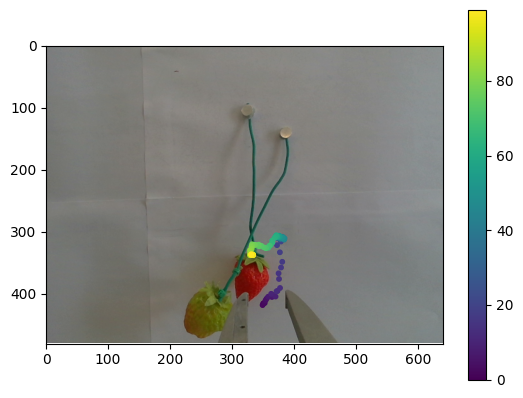

In [37]:

img_plot = img_wrist_up_np.copy()

plt.imshow(cv.cvtColor(img_wrist_up_np, cv.COLOR_BGR2RGB))
plt.scatter(uvs[:, 0], uvs[:, 1], c=range(len(uvs)), s=10)
# limit the axis to the image shape
plt.xlim([0, img_wrist_up_np.shape[1]])
plt.ylim([img_wrist_up_np.shape[0], 0])
plt.colorbar()